# Further Model Evaluation, Multinomial Logistic Regression, and Regularisation

In [43]:
import numpy as np
import pandas as pd
from patsy import dmatrix

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import itertools

In [2]:
pd.set_option("display.max_columns", 100)

## Ridge (l2) and Lasso (l1) Regularisation applied to Logistic Regression

Ridge and lasso regularisation have been discussed in the context of linear regression. Similarly in the case of logistic regression, ridge is adding a penalty term in relation to the square of coefficients (hence l2) and lasso is adding a term in relation to the absolute value of coefficients (l1) when penalising increasing magnitude of coefficients in the fit. 

This aims to reduce the influence of individual terms in order to mitigate overfitting (this forms a prior on our expected outcome, in the context of Bayesian statistics). This penalty term is then removed from the log likelihood calculation (which is the term we seek to maximise when iterating the logistic regression function to find the fit of coefficients, this is something that is performed under the hood of the fitting algorithm).

Something we did not discuss is that in the sklearn implementation of logistic regression, such regularisation is applied by default. In fact l2 regularisation is the default, and it is not actually possible to turn this off (only to select l2 or l1). How can we affect this regularisation, to tune its impact? We have a C score hyperparameter which we can tune, which is the inverse of the regularisation strength (usually termed lambda). Slightly confusingly, this means that the larger C is the smaller the regularisation effect. If we wanted to produce a case without regularisation, we can hence set C to an absurdly high number (such as 1e10).

But how can we decide on what the best value of C is for our particular case? We can perform a grid search to test a range of values, and sklearn implements this quite straightforwardly.

## Grid Search and setting C hyperparameter in the context of Binomial Logistic Regression

In order not to cover too many topics at once, let's check out the grid search process for a binomial logistic regression
before we take a look at the multinomial case. We can go back to a dataset we modelled previously.

In [3]:
# here is the wine dataset - we are predicting high quality
df = pd.read_csv("https://s3.amazonaws.com/demo-datasets/wine.csv")
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color,is_red,high_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red,1.0,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red,1.0,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red,1.0,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red,1.0,0.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red,1.0,0.0


In [4]:
# Let's fit a model with sklearn
X=df[["density","pH", "alcohol"]]
y=df["high_quality"]

# train test split with a stratify term on the outcome to keep datasets balanced on the three outcomes
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=77)

In [5]:
model1=LogisticRegression()
model1.fit(X_train, Y_train)
predictions1=model1.predict(X_test)

In [6]:
cnf_matrix=confusion_matrix(Y_test, predictions1)
cnf_matrix

array([[1666,   57],
       [ 341,   81]])

In [7]:
# As we know, this output of a confusion matrix is a bit awkward and confusing
# Here is some nice code to plot a confusion matrix in an easier to read way,
# this is from sklearn's documentation

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(cnf_matrix, classes=model1.classes_)

In [8]:
# Not a great classifer, but anyway let's talk about the regularisation going on here
# in fact, LogisticRegression() is implementing the following as default

model1=LogisticRegression(penalty='l2', C=1.0)
model1.fit(X_train, Y_train)
predictions1=model1.predict(X_test)
cnf_matrix=confusion_matrix(Y_test, predictions1)
cnf_matrix

array([[1666,   57],
       [ 341,   81]])

In [9]:
# And you can see the result is the same, because this is what we ran the first time anyway without
# inputting any values as these are the default. If we change the hyperparameter C we can change the fit

model2=LogisticRegression(C=100)
model2.fit(X_train, Y_train)
predictions2=model2.predict(X_test)
cnf_matrix2=confusion_matrix(Y_test, predictions2)
cnf_matrix2

array([[1675,   48],
       [ 338,   84]])

In [10]:
# Below is the accuracy, by which sklearn is generally optimising when running a cross validation
# (though check for any particular model what 'score' returns by looking at the documentation)

print(model1.score(X_test, Y_test))
print(model2.score(X_test, Y_test))

0.814452214452
0.820046620047


In [11]:
# Looks like the second C was better than the first, so I guess we should tune this!
# Ok, all these things to tune is getting exhausting! Well, that's actually what being a data scientist
# is about :) But don't worry, sklearn can at least make this easier with grid search to iterate over
# different C values to test which gives the best cross validation accuracy results. That sounds good to me!
# What is the liblinear? This is the solver used for maximising the log likelihood, we state it explicitly
# here to ensure consistent results (generally you can trust sklearn to use the most computationally
# optimal solving algorithm)

logreg_cv1 = LogisticRegressionCV(Cs=15, cv=5, random_state=5, solver='liblinear')
logreg_cv1.fit(X_train, Y_train)
logreg_cv1.Cs_

array([  1.00000000e-04,   3.72759372e-04,   1.38949549e-03,
         5.17947468e-03,   1.93069773e-02,   7.19685673e-02,
         2.68269580e-01,   1.00000000e+00,   3.72759372e+00,
         1.38949549e+01,   5.17947468e+01,   1.93069773e+02,
         7.19685673e+02,   2.68269580e+03,   1.00000000e+04])

In [14]:
# So here when we input Cs=15, we are saying we want a logarithmic range of 15 different Cs spanning
# the range from 1e-4 to 1e4, and if we call the .Cs_ we output the Cs that were actually used
# in the CV cycle of fittings. But which was the best one? The one which best fits the scoring metrics
# out of the ones tested is called with .C_ (in this case, we used the accuracy score)

best_C=logreg_cv1.C_
best_C=float(best_C)
print(best_C)

13.8949549437


In [15]:
# You can return the scores with this, they were all pretty similar in this case

logreg_cv1.scores_

{1.0: array([[ 0.80367394,  0.80367394,  0.80367394,  0.80367394,  0.80482204,
          0.80137773,  0.80022962,  0.81056257,  0.80826636,  0.80941447,
          0.80941447,  0.80941447,  0.80941447,  0.80941447,  0.80941447],
        [ 0.80367394,  0.80367394,  0.80367394,  0.80367394,  0.80367394,
          0.81171068,  0.81745121,  0.82319173,  0.81974742,  0.82204363,
          0.82319173,  0.82319173,  0.82319173,  0.82319173,  0.82319173],
        [ 0.80344828,  0.80344828,  0.80344828,  0.80344828,  0.80344828,
          0.8045977 ,  0.81494253,  0.81609195,  0.8183908 ,  0.81954023,
          0.81494253,  0.8137931 ,  0.81149425,  0.81149425,  0.81149425],
        [ 0.80344828,  0.80344828,  0.80344828,  0.80344828,  0.80229885,
          0.80114943,  0.79885057,  0.80344828,  0.8045977 ,  0.80574713,
          0.80574713,  0.80574713,  0.80574713,  0.80574713,  0.80574713],
        [ 0.80344828,  0.80344828,  0.80344828,  0.80344828,  0.80229885,
          0.80229885,  0.8114

In [16]:
# So now we can run our logistic regression model with the C parameter we decided upon

model3=LogisticRegression(C=best_C)
model3.fit(X_train, Y_train)
predictions3=model3.predict(X_test)
cnf_matrix3=confusion_matrix(Y_test, predictions3)
cnf_matrix3
plot_confusion_matrix(cnf_matrix3, classes=model3.classes_)

array([[1675,   48],
       [ 338,   84]])

In [17]:
# So this is our best accuracy
print(model3.score(X_test, Y_test))

0.820046620047


## Multinomial Logistic Regression and Grid Search

Ok, so now we have some idea about this process let's also investigate for a multinomial logistic regression.

Previously we have introduced logistic regression as a format to return a probability for being in one of two classes
(e.g. defaulted on loan or not, passed test or not). However, we can also use logistic regression for multiclass problems. This is multinomial logistic regression (as opposed to binomial logistic regression). An example might
be whether someone will buy one of five different products from your website, depending on their browsing habits and geolocation.

In this case, we consider separate logistic fits for each outcome (actually, each outcome minus one) and then compare the results with each other (all within one model implementation).

For this to work there are some assumptions, such as that only one outcome is valid (i.e. outcomes should be mutually exclusive). They are also complete, in that there isn't another possible outcome (or rather, our model will miss this information if it is not included in the fit).

You can fit this in such a way that each possible outcome is fit against all others (one-vs-rest), and this is then cycled through for each of the possible outcomes (actually the total number of outcomes minus one, and you calculate the last probability by just seeing what the remaining probability is compared to a total of 1). Hence rather than fitting an outcome vs no outcome binomial case, you are fitting for an outcome vs all other outcomes multinomial case (note that it's also possible to implement a separate multinomial classifier algorithm, but we need not get into this distinction).

Hence, with each cycle through, you find the probability of one outcome (so that's your 1 in the binary case) compared to any other outcome (so that's your 0). You then go through the other cases until (if there are n outcomes) you have fit n-1 cases, and for the last you compare the sum of the previous probabilities to 1 so that in each case the total probability sums to 1 - meaning you have covered all possible outcomes in the model.

In [20]:
# Let's get another dataset from our favourite site, kaggle
# This one is https://www.kaggle.com/c/sf-crime/data
# Please download and put in the same directory as this file

sf_crime = pd.read_csv("train.csv.zip")
sf_crime = sf_crime.dropna()
sf_crime['Dates'] = pd.to_datetime(sf_crime.Dates)
sf_crime['hour'] = sf_crime['Dates'].dt.hour
sf_crime['month'] = sf_crime['Dates'].dt.month
sf_crime['year'] = sf_crime['Dates'].dt.year

In [42]:
categories_to_use = ['VEHICLE THEFT','BURGLARY','DRUG/NARCOTIC']
sf_crime_sub = sf_crime[sf_crime['Category'].str.contains('|'.join(categories_to_use))]
sf_crime_sub=sf_crime_sub.loc[0:200000,:]

In [40]:
# subset out these columns as predictors
subset=sf_crime_sub[["hour", "DayOfWeek", "PdDistrict"]]

# create dummy variables for them
X=pd.get_dummies(subset, columns=["hour", "DayOfWeek", "PdDistrict"], drop_first=True)

# separate out the outcome but in this case don't create dummy variables, sklearn can handle this
# so this means we are looking to predict three categories
y=sf_crime_sub["Category"]

In [36]:
X.head()

,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
y.value_counts()

VEHICLE THEFT    9138
BURGLARY         8161
DRUG/NARCOTIC    7788
Name: Category, dtype: int64

In [24]:
# train test split with a stratify term on the outcome to keep datasets balanced on the three outcomes
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=77)

In [25]:
logreg=LogisticRegression(penalty='l2', C=1.0)
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
# We output the three classes so we can read the numpy array of
# probabilities, these will be in the same order

logreg.classes_

array(['BURGLARY', 'DRUG/NARCOTIC', 'VEHICLE THEFT'], dtype=object)

In [27]:
# Ok, so you can see for these cases which of the three classes has the
# highest probability, that will be the one selected by the model when you
# call the predict function (which tells you the most likely outcome)

y_pred=logreg.predict_proba(X_test)
y_pred[10:20]

array([[ 0.13500752,  0.80834286,  0.05664962],
       [ 0.43558074,  0.13823595,  0.42618331],
       [ 0.31707555,  0.32953778,  0.35338667],
       [ 0.24962164,  0.40022098,  0.35015739],
       [ 0.34014617,  0.07196238,  0.58789146],
       [ 0.38205162,  0.10921418,  0.5087342 ],
       [ 0.27607142,  0.37025253,  0.35367606],
       [ 0.15322909,  0.8130883 ,  0.0336826 ],
       [ 0.45800788,  0.14266948,  0.39932263],
       [ 0.09517009,  0.84489178,  0.05993813]])

In [27]:
# So compare this output to the above, you can see that in each
# of the cases the class label corresponds to the column which had
# the highest probability assigned

y_pred2=logreg.predict(X_test)
y_pred2[10:20]

array(['DRUG/NARCOTIC', 'BURGLARY', 'VEHICLE THEFT', 'DRUG/NARCOTIC',
       'VEHICLE THEFT', 'VEHICLE THEFT', 'DRUG/NARCOTIC', 'DRUG/NARCOTIC',
       'BURGLARY', 'DRUG/NARCOTIC'], dtype=object)

In [28]:
# Great, so we ran logistic regression in a case where we had three possible outcomes
# instead of just two. Now let's have a look at running grid search to test for the optimal C
# value (C = inverse of regularisation strength)

logreg_cv = LogisticRegressionCV(Cs=15, cv=5, solver='liblinear', scoring='accuracy')
logreg_cv.fit(X_train, Y_train)

LogisticRegressionCV(Cs=15, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='accuracy', solver='liblinear', tol=0.0001,
           verbose=0)

In [29]:
# find best C per class
print('best C for class:')
best_C = {logreg_cv.classes_[i]:x for i, (x, c) in enumerate(zip(logreg_cv.C_, logreg_cv.classes_))}
print(best_C)

best C for class:
{'BURGLARY': 1.0, 'VEHICLE THEFT': 0.26826957952797248, 'DRUG/NARCOTIC': 0.071968567300115138}


In [30]:
# fit regular logit model to 'DRUG/NARCOTIC' and 'BURGLARY' classes
# use ridge penalty
logreg_1 = LogisticRegression(C=best_C['BURGLARY'], solver='liblinear')
logreg_2 = LogisticRegression(C=best_C['DRUG/NARCOTIC'], solver='liblinear')
logreg_3 = LogisticRegression(C=best_C['VEHICLE THEFT'], solver='liblinear')
logreg_1.fit(X_train, Y_train)
logreg_2.fit(X_train, Y_train)
logreg_3.fit(X_train, Y_train)

LogisticRegression(C=0.26826957952797248, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [31]:
logreg_cv.scores_

{'BURGLARY': array([[ 0.67469521,  0.67469521,  0.67469521,  0.67469521,  0.68480523,
          0.6907523 ,  0.68926554,  0.68986024,  0.69045495,  0.69045495,
          0.69045495,  0.69045495,  0.69045495,  0.69045495,  0.69045495],
        [ 0.67469521,  0.67469521,  0.67469521,  0.67647933,  0.68867083,
          0.68748142,  0.68777877,  0.68807612,  0.68807612,  0.68837348,
          0.68837348,  0.68837348,  0.68837348,  0.68837348,  0.68837348],
        [ 0.67459845,  0.67459845,  0.67459845,  0.67430101,  0.68262939,
          0.6876859 ,  0.68679358,  0.68679358,  0.68679358,  0.68679358,
          0.68679358,  0.68679358,  0.68679358,  0.68679358,  0.68679358],
        [ 0.67470238,  0.67470238,  0.67470238,  0.675     ,  0.67738095,
          0.67946429,  0.67916667,  0.67857143,  0.67857143,  0.67857143,
          0.67827381,  0.67827381,  0.67827381,  0.67827381,  0.67827381],
        [ 0.67470238,  0.67470238,  0.67470238,  0.67529762,  0.68095238,
          0.6860119 , 

In [32]:
# predict and build confusion matrices for the models above
Y_1_pred = logreg_1.predict(X_test)
Y_2_pred = logreg_2.predict(X_test)
Y_3_pred = logreg_3.predict(X_test)

conmat_1 = confusion_matrix(Y_test, Y_1_pred, labels=logreg_1.classes_)
conmat_2 = confusion_matrix(Y_test, Y_2_pred, labels=logreg_2.classes_)
conmat_3 = confusion_matrix(Y_test, Y_3_pred, labels=logreg_3.classes_)

print(conmat_1)
print(conmat_2)
print(conmat_3)

[[1072  507 1114]
 [ 494 1277  799]
 [ 647  411 1958]]
[[1087  494 1112]
 [ 509 1270  791]
 [ 656  418 1942]]
[[1084  501 1108]
 [ 502 1275  793]
 [ 652  409 1955]]


In [34]:
# print classification reports
print(classification_report(Y_test, Y_1_pred))
print(classification_report(Y_test, Y_2_pred))
print(classification_report(Y_test, Y_3_pred))

               precision    recall  f1-score   support

     BURGLARY       0.48      0.40      0.44      2693
DRUG/NARCOTIC       0.58      0.50      0.54      2570
VEHICLE THEFT       0.51      0.65      0.57      3016

  avg / total       0.52      0.52      0.52      8279

               precision    recall  f1-score   support

     BURGLARY       0.48      0.40      0.44      2693
DRUG/NARCOTIC       0.58      0.49      0.53      2570
VEHICLE THEFT       0.51      0.64      0.57      3016

  avg / total       0.52      0.52      0.52      8279

               precision    recall  f1-score   support

     BURGLARY       0.48      0.40      0.44      2693
DRUG/NARCOTIC       0.58      0.50      0.54      2570
VEHICLE THEFT       0.51      0.65      0.57      3016

  avg / total       0.52      0.52      0.52      8279



To decide which C to use in this case, it may depend on our problem if we wish to give
the best performance to one of our classes for example (e.g. that is the high end product we really
want to predict if our customers will buy). Or perhaps we would need to use some average of the scores in each case
but we would have to do this manually to see which is the best C. 

Furthermore we glossed over slightly whether
to use l1 or l2 penalties. This may also depend on the extent to which you wish to see certain outcomes (for
example, as previously discussed the lasso l1 penalty will return some coefficients as zero, so can be used for
automated feature selection - which is useful if you have very large numbers of possible features).

So instead, we can use sklearn's GridSearchCV function to do this for us. This abstracts away all those decisions
and finds the best overall performance across all classes. So which approach to use depends on your
particular problem and the extent to which you want to dive deep into it. But GridSearchCV can iteratively try
a lot of different approaches and then tell you which one performed the best. So it does lots of the hard work for you. Doesn't that sound great!

We can actually search through any of the parameters in the LogisticRegression() model that we want to test with this function, and we can of course use it for other fitting algorithms as well. So this is very powerful.

In [41]:
# This will take a bit of time (should be < 1 min)
# Go through this and check it makes sense
# Check the documentation, there are many possible scorings you can use

logreg_f = LogisticRegression()
C_vals = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg_f, {'penalty':penalties, 'C':C_vals}, verbose=True, cv=5, scoring='accuracy')
gs.fit(X_train, Y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   25.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [42]:
# these are the parameters we tested, we could also have tested others too
gs.best_params_

{'C': 0.1, 'penalty': 'l1'}

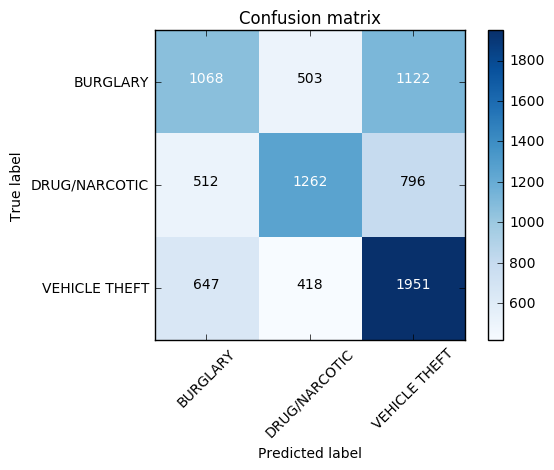

               precision    recall  f1-score   support

     BURGLARY       0.48      0.40      0.43      2693
DRUG/NARCOTIC       0.58      0.49      0.53      2570
VEHICLE THEFT       0.50      0.65      0.57      3016

  avg / total       0.52      0.52      0.51      8279



In [43]:
gs_logreg = LogisticRegression(C=gs.best_params_["C"], penalty=gs.best_params_["penalty"], solver='liblinear')
gs_logreg.fit(X_train, Y_train)
Y_ = gs_logreg.predict(X_test)
conmat_gs_logreg = confusion_matrix(Y_test, Y_, labels=gs_logreg.classes_)
plot_confusion_matrix(conmat_gs_logreg, classes=gs_logreg.classes_)
print(classification_report(Y_test, Y_))

In [44]:
gs_logreg.score(X_test, Y_test)

0.51709143616378794

That's our best model in this case! Try playing around, and perhaps adding in new features and running through the
process again using GridSearchCV so you don't have to take so many steps!